In [1]:
%load_ext autoreload
# to make modification in .py file type %autoreload

%load_ext line_profiler
#for finding out how long code takes to run
#an example of how to get diagnostics on functions
#%lprun -f ff.generate_map_full ff.generate_map_full(384, A_BB, alpha_BB, beta_sigma, freqs, nu0)

In [2]:
#trying to consolidate the work so far into a cohesive document and notation. Pushing definitions into 
#separate .py file

#------packages-------------------
%pylab inline
import time
import healpy as hp
import matplotlib.pyplot as plt
import foreground_functions as ff
from scipy.optimize import curve_fit, minimize

Populating the interactive namespace from numpy and matplotlib


# parameters for generating map

In [18]:
nside = 128
A = 1.7e3
alpha = -3.0
beta = -3.2
gamma = -2.5
ells = np.arange(3*nside)
freqs = np.linspace(30, 300, 5)*1.e9
input_params = [A, alpha, beta, gamma]
#create a filepath to store different power spectra
filepath = '/Users/alex/Documents/foreground_moments/power_spectra/'

# define the input model

In [52]:
%autoreload

In [55]:
start=time.time()
in_model = ff.model(ells, freqs, input_params)
print(time.time()-start)

0.08233880996704102


# define the 2d data we're going to try to fit

In [56]:
#averaged 100 PS
PS_data = np.load('reference_mean_PS.npy').T

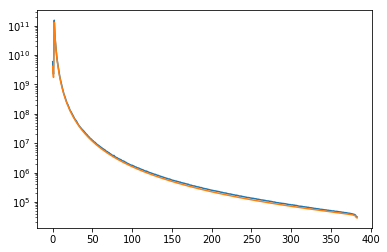

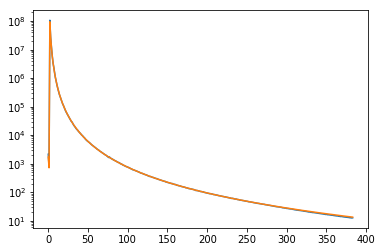

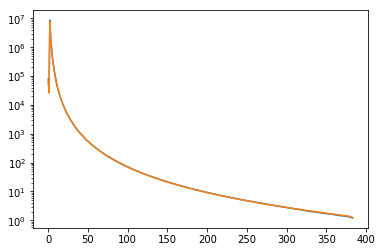

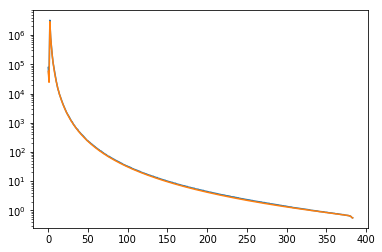

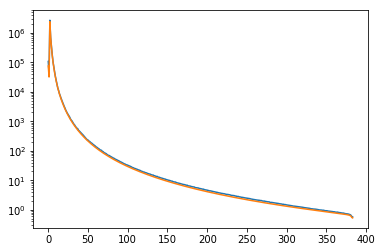

In [57]:
for i in range(len(freqs)):
    figure()
    semilogy(mean_PS_data[i])
    semilogy(in_model[i])

# define our objective function (chi2 with cosmic variance) -- ultimately modify this for the behaviour near the high end cut off tail? Add additional uncertainty due to finite precision of the map?

In [71]:
def chi2(params, ells, freqs, data):
    chi2=0
    A, alpha, beta, gamma = params
    model = ff.model(ells, freqs, params)
    
    var = np.zeros((len(freqs),len(ells)))
    for ell in range(len(ells)):
        var[:,ell] = 2/(2*ell+1)
    cosmic_var = var * model**2
    chi2 = (data[2:200] - model[2:])**2 / cosmic_var[2:]
    return np.sum(chi2)

In [72]:
start=time.time()
result0 = minimize(chi2, [1, -1, -1, -3], args=(ells, freqs, PS_data), 
                  method='L-BFGS-B', bounds=((None, None), (None, None), (None, None), (None, -2.01)))
print(time.time()-start)
print(result0)

64.60333490371704
      fun: 97.94679042667394
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.13686838e-05,  1.33312028e-02, -5.56568125e-02, -1.55637281e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 920
      nit: 139
   status: 0
  success: True
        x: array([1539.67259555,   -3.01051206,   -3.10526494,   -2.52374525])


In [74]:
#getting there, moving all the parameters, and it's getting the exponents basically right, it just can't get
#the amplitude right

In [76]:
x0 = result0.x
fit0 = ff.model(ells, freqs, x0)
print(chi2(input_params, ells, freqs, PS_data))
print(chi2(x0, ells, freqs, PS_data))
#is there something wrong with the objective function as written?

1049.9134290217191
97.94679042667394


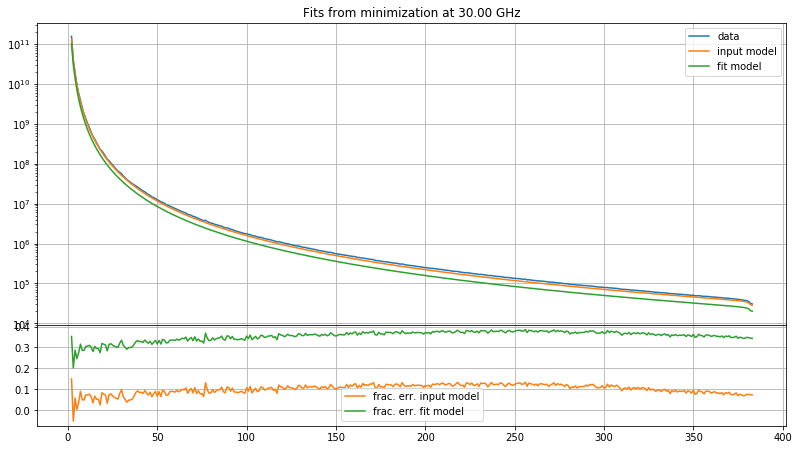

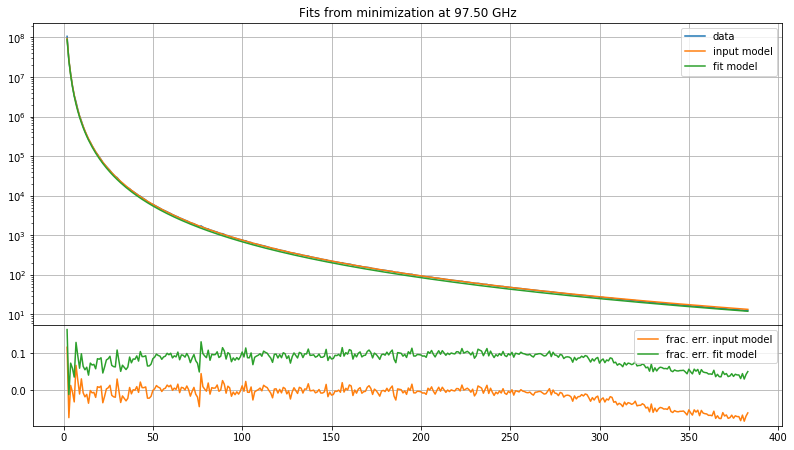

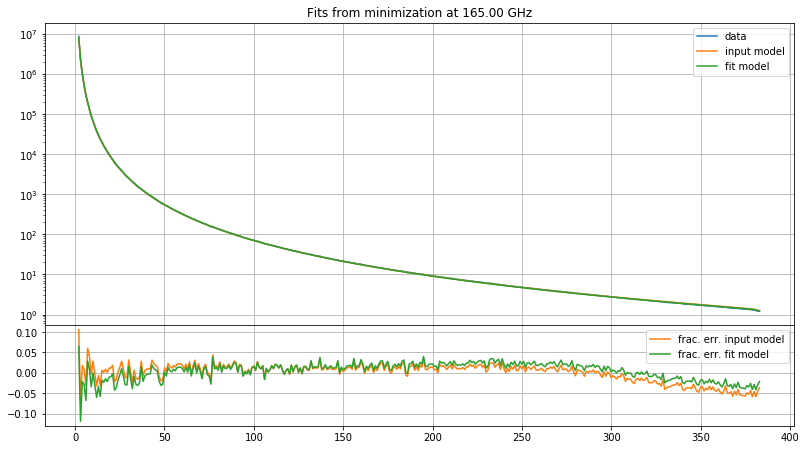

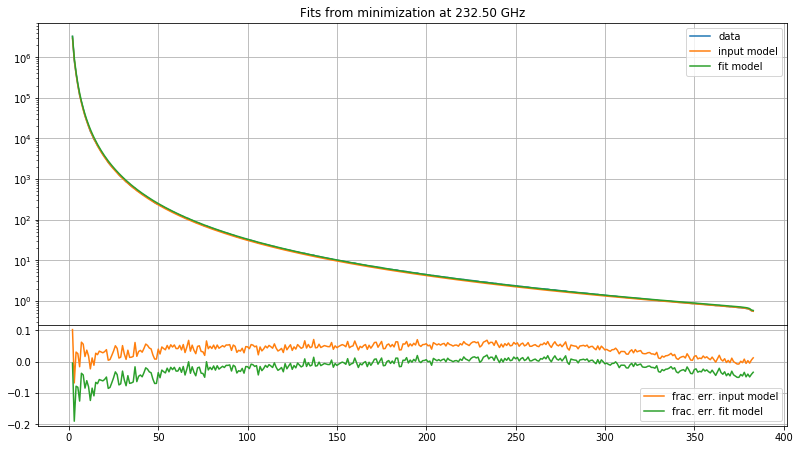

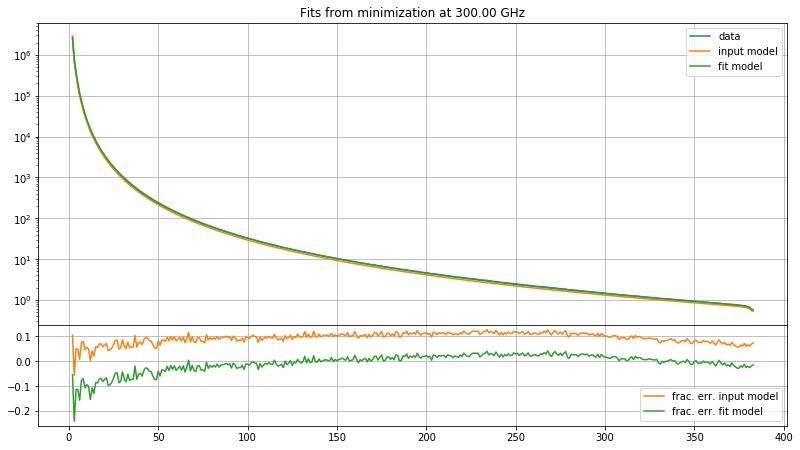

In [77]:
for i in range(len(freqs)):
    fig1 = figure(figsize=(13,7))
    frame1=fig1.add_axes((.1,.3,.8,.6))
    frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
    semilogy(ells[2:], PS_data[i][2:], label='data')
    semilogy(ells[2:], input_model[i][2:], label='input model', color='C1')
    semilogy(ells[2:], fit0[i][2:], label='fit model', color='C2')
    ylabel=r'$C_\ell$'
    grid()
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
    legend()
    
    
    
    frame2=fig1.add_axes((.1,.1,.8,.2)) 
    plot(ells[2:], (PS_data[i][2:]-input_model[i][2:])/PS_data[i][2:], color='C1', label='frac. err. input model')
    plot(ells[2:], (PS_data[i][2:]-fit0[i][2:])/PS_data[i][2:], color='C2', label='frac. err. fit model')
    legend()
    grid()
#     xlim(2,400)

In [ ]:
#still seems to be prioritizing the higher freqencies in the fits, at least visually